<img src = "https://github.com/exponentialR/DL4CV/blob/main/media/BMC_Summer_Course_Deep_Learning_for_Computer_Vision.jpg?raw=true" alt='BMC Summer Course' width='300'/>

### BMC Summer Course: Deep Learning for Computer Vision, VGG-Like CNN on CIFAR-10 Dataset with PyTorch

Author: Samuel A.

This notebook will guide you through implementing a VGG-like convolutional neural network (CNN) using PyTorch, training it on the CIFAR-10 dataset, and visualising the learned features. By the end of this notebook, you should have a strong understanding of how to build, train, and evaluate a CNN, as well as how to use TensorBoard to visualise your model's performance.

## **Step 1: Import Necessary Libraries**

First, we need to import the necessary libraries. These include PyTorch for building and training our model, `torchvision` for loading the CIFAR-10 dataset, and `matplotlib` for visualising images.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


- **Explanation**: 
  - **`torch` and `torch.nn`**: Core libraries for building and training neural networks in PyTorch.
  - **`torchvision`**: Contains popular datasets, model architectures, and image transformations for computer vision tasks.
  - **`matplotlib.pyplot`**: Used for plotting and visualisation.
  - **`device`**: Automatically selects GPU if available, otherwise defaults to CPU.


## **Step 2: Load and Preprocess the CIFAR-10 Dataset**

The CIFAR-10 dataset consists of 60,000 32x32 colour images in 10 different classes (e.g., airplanes, cars, birds, etc.). We will load the dataset and apply some basic preprocessing steps such as normalisation.


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
# Load the training and test datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:53<00:00, 3197153.74it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


- **Explanation**:
  - **Transformations**: We convert images to PyTorch tensors and normalise them to have a mean of 0.5 and a standard deviation of 0.5 for each channel (RGB). This scaling helps the model converge faster during training.
  - **DataLoader**: Wraps the dataset into an iterable and allows for easy access to mini-batches during training. The `batch_size` is set to 64, meaning the model will process 64 images at a time.
  - **Classes**: The 10 different categories of images in CIFAR-10.


### **Visualising Some Training Images**

Let's visualise a few images from the training set to understand what our model will be learning to classify.

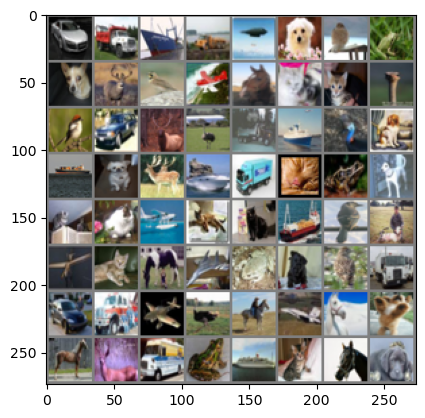

car   truck ship  truck


In [5]:
# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

- **Explanation**:
  - **`imshow` function**: This helper function unnormalises the images and uses `matplotlib` to display them.
  - **Visualisation**: We randomly select a batch of images from the training set and display them along with their labels.

## **Step 3: Define the VGG-Like CNN Model**

Now we define our VGG-like CNN model. This architecture is inspired by the VGG network but simplified for faster training on CIFAR-10. VGG networks are characterised by their use of small convolutional filters (3x3) and deep architecture.
<img src = "https://miro.medium.com/v2/resize:fit:1200/1*NNifzsJ7tD2kAfBXt3AzEg.png" alt='VGG-Image' width='400'/>

In [6]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [7]:
# Instantiate the model, move it to the appropriate device
net = VGG().to(device)

- **Explanation**:
  - **`nn.Conv2d`**: Applies a 2D convolution operation. The kernel size is 3x3, and padding is set to 1 to maintain the spatial dimensions of the input.
  - **`nn.ReLU`**: Activation function that introduces non-linearity to the network.
  - **`nn.MaxPool2d`**: Downsamples the input by taking the maximum value over a specified window, effectively reducing the spatial dimensions.
  - **Classifier**: The fully connected layers at the end are responsible for the final classification. The output layer has 10 neurons corresponding to the 10 classes of CIFAR-10.


## **Step 4: Define the Loss Function and Optimizer**

Next, we define the loss function and the optimizer. We'll use cross-entropy loss, which is standard for classification tasks, and the Adam optimizer, which adapts the learning rate during training for faster convergence.



In [9]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)


- **Explanation**:
  - **`nn.CrossEntropyLoss`**: Combines `LogSoftmax` and `NLLLoss` in one single class. It's used for classification problems where the model outputs raw class scores.
  - **`optim.Adam`**: An adaptive learning rate optimization algorithm that has proven to work well in practice for many deep learning models.


## **Step 5: Train the Model**

We now train the model using the training data. The model will pass the data through the network, calculate the loss, and adjust the weights using backpropagation.


In [11]:
# Train for a specified number of epochs
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:  # print every 100 mini-batches
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished Training')

[Epoch 1, Batch 100] loss: 2.306
[Epoch 1, Batch 200] loss: 2.309



KeyboardInterrupt



- **Explanation**:
  - **Training Loop**: The training loop iterates over the dataset multiple times (epochs). In each epoch, the model processes the entire dataset, adjusting weights to minimize the loss.
  - **`optimizer.zero_grad()`**: Clears old gradients from the last step before the new one is computed.
  - **`loss.backward()`**: Computes the gradient of the loss with respect to model parameters (backpropagation).
  - **`optimizer.step()`**: Updates the model parameters based on the gradients.

## **Step 6: Evaluate the Model on Test Data**

After training, we evaluate the model's performance on the test data to see how well it has learned to generalise.


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

- **Explanation**:
  - **Evaluation**: The model is tested on unseen data (test set) to measure its accuracy. No gradients are calculated during this phase (`torch.no_grad()`), making it more memory efficient.
  - **Accuracy Calculation**: The accuracy is computed as the percentage of correct predictions out of the total test images.


## **Step 7: Visualise Feature Maps**

Understanding what the model has learned is crucial. We can visualise the feature maps (or activations) of the first convolutional layer to see what kind of features (e.g., edges, textures) the model is detecting.



In [ ]:
# Visualise feature maps of the first convolutional layer
def visualize_feature_maps(model, layer_num, input_image):
    with torch.no_grad():
        layer = list(model.features.children())[layer_num]
        feature_map = layer(input_image)
        for i in range(feature_map.shape[1]):
            plt.subplot(8, 8, i + 1)
            plt.imshow(feature_map[0, i].cpu().numpy(), cmap='viridis')
            plt.axis('off')
        plt.show()


In [ ]:
# Use a sample image from the test set
sample_image = images[0].unsqueeze(0)
visualize_feature_maps(net, 0, sample_image)



- **Explanation**:
  - **Feature Maps**: Visualising the outputs of a specific layer can give insights into what the model is focusing on at each stage.
  - **Layer Selection**: In this example, we visualise the activations of the first convolutional layer (layer_num = 0).

## **Step 8: Save and Load the Model (Optional)**

Saving the trained model allows you to load it later for further training or inference without retraining from scratch.


In [ ]:

# Save the model
PATH = './cifar_vgg.pth'
torch.save(net.state_dict(), PATH)

# Load the model (for inference or further training)
net = VGG()
net.load_state_dict(torch.load(PATH))
net = net.to(device)


- **Explanation**:
  - **Model Saving**: `torch.save()` saves the model's state dictionary, which contains all the parameters of the model.
  - **Model Loading**: `torch.load()` loads the saved model state dictionary, allowing you to restore the model's state.


## **Step 9: Visualisation with TensorBoard**

TensorBoard is a tool for visualising metrics such as loss and accuracy, and it can also display the model graph. Here’s how to set up TensorBoard in PyTorch.


In [ ]:
from torch.utils.tensorboard import SummaryWriter

# Create a SummaryWriter to log the model
writer = SummaryWriter('runs/vgg_experiment_1')

# Log the model graph
sample_input = torch.zeros((1, 3, 32, 32)).to(device)
writer.add_graph(net, sample_input)
writer.close()

In [ ]:
# To view, run this in your terminal:
# tensorboard --logdir=runs


- **Explanation**:
  - **`SummaryWriter`**: This creates a log directory where TensorBoard will save the logs.
  - **Logging the Graph**: By passing a sample input through the model, TensorBoard can visualize the computational graph.
  - **Viewing TensorBoard**: Run `tensorboard --logdir=runs` in your terminal to start TensorBoard and view the logs.


## **Conclusion**

This notebook walked you through implementing a VGG-like architecture using PyTorch, training it on CIFAR-10, and visualising the learned features. The model's performance can be further improved by fine-tuning hyperparameters, augmenting data, or increasing training epochs. This hands-on exercise should provide you with a solid foundation in CNNs and how to work with them using PyTorch.
